#### This notebooks works with the code from the edm paper: https://github.com/NVlabs/edm


In [1]:
import tqdm
import pickle
import numpy as np
import torch
import PIL.Image
import dnnlib
import matplotlib.pyplot as plt

from torch_utils import distributed as dist
from torch_utils import misc

/home/sbordt/anaconda3/envs/deeplearning/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_root = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained'
network_pkl= f'{model_root}/edm-cifar10-32x32-cond-vp.pkl'
device=torch.device('cuda')

c = dnnlib.EasyDict()
c.dataset_kwargs = dnnlib.EasyDict(class_name='training.dataset.ImageFolderDataset', path='datasets/cifar10-32x32.zip', use_labels=False, xflip=False, cache=True)
c.data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, num_workers=2, prefetch_factor=2)
seed = 0
batch_size           = 64     # Limit batch size per GPU, None = no limit.

### Load the diffusion model

In [3]:
# Load network.
# it is of type EDMPrecond so the pre-conditioning discussed in the paper is performed by net automaticall. that is net computes effectivly D_\theta(x,sigma,class-conditioning)
print(f'Loading network from "{network_pkl}"...')
with dnnlib.util.open_url(network_pkl) as f:
    net = pickle.load(f)['ema'].to(device)

Loading network from "https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-cond-vp.pkl"...


In [4]:
print("Network Supports Noise Level (Min/Max):", net.sigma_min, net.sigma_max)

Network Supports Noise Level (Min/Max): 0 inf


### Load the CIFAR10 dataset
##### the images are scaled to lie in [-1,1]

In [5]:
import torchvision

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [32]:
images = iter(trainloader).__next__()
images = images[0].to(device).to(torch.float32) * 2 -1

In [7]:
images.min(),images.max()

(tensor(-1., device='cuda:0'), tensor(1., device='cuda:0'))

### Visualize the score function of the diffusion model for various levels of noise

In [27]:
def save_image_grid(dest_path, x, gridh=8, gridw=8):
    # Save image grid.
    print(f'Saving image grid to "{dest_path}"...')
    image = (x * 127.5 + 128).clip(0, 255).to(torch.uint8)
    image = image.reshape(gridh, gridw, *image.shape[1:]).permute(0, 3, 1, 4, 2)
    image = image.reshape(gridh * net.img_resolution, gridw * net.img_resolution, net.img_channels)
    image = image.cpu().numpy()
    pil_img = PIL.Image.fromarray(image, 'RGB')
    pil_img.save(dest_path)
    plt.imshow(pil_img)
    plt.show()
    print('Done.')

In [21]:
score.device, images.device

(device(type='cuda', index=0), device(type='cuda', index=0))

-------- Sigma: 0.001 -------
L2 Norm: 21850.086
Cosine Similarity with Image: -0.008


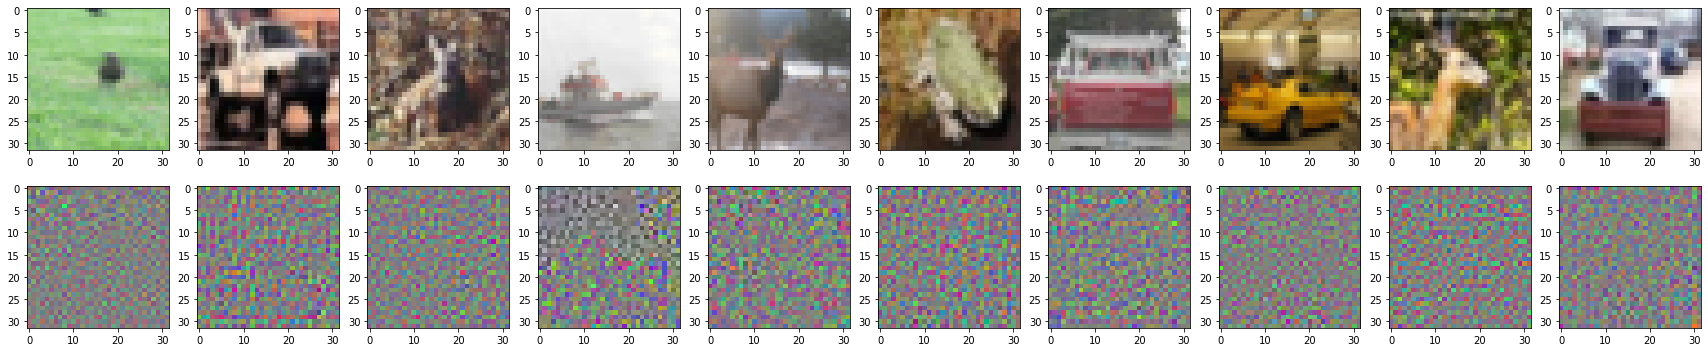

-------- Sigma: 0.003 -------
L2 Norm: 8113.790
Cosine Similarity with Image: -0.016


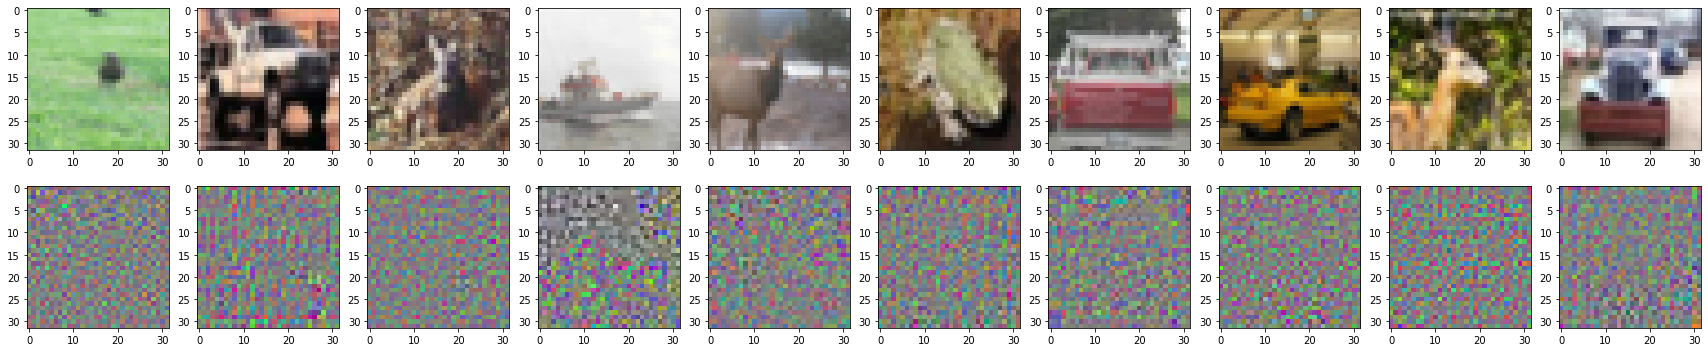

-------- Sigma: 0.008 -------
L2 Norm: 3048.358
Cosine Similarity with Image: -0.021


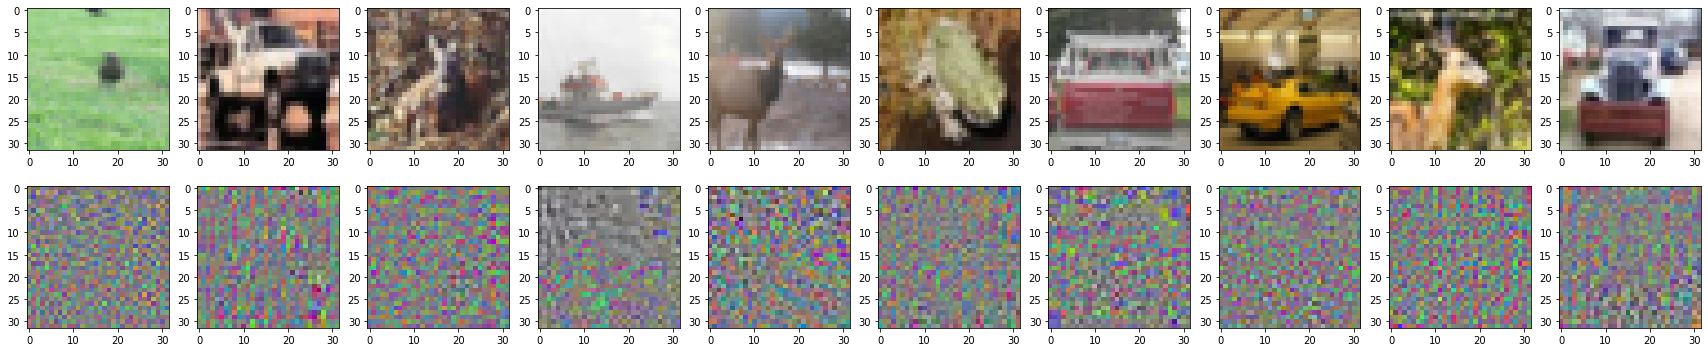

-------- Sigma: 0.022 -------
L2 Norm: 1047.643
Cosine Similarity with Image: -0.029


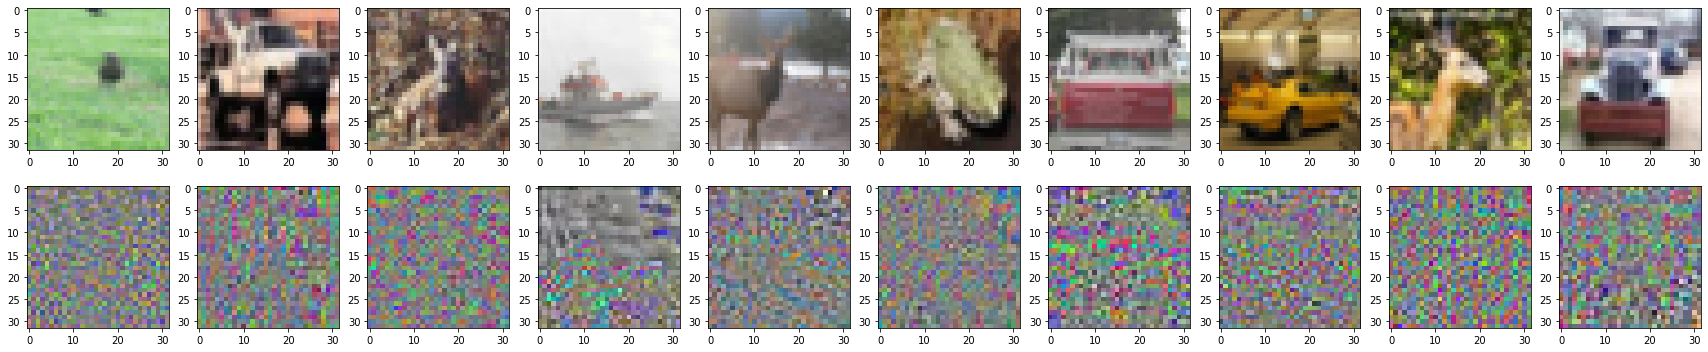

-------- Sigma: 0.060 -------
L2 Norm: 313.745
Cosine Similarity with Image: -0.043


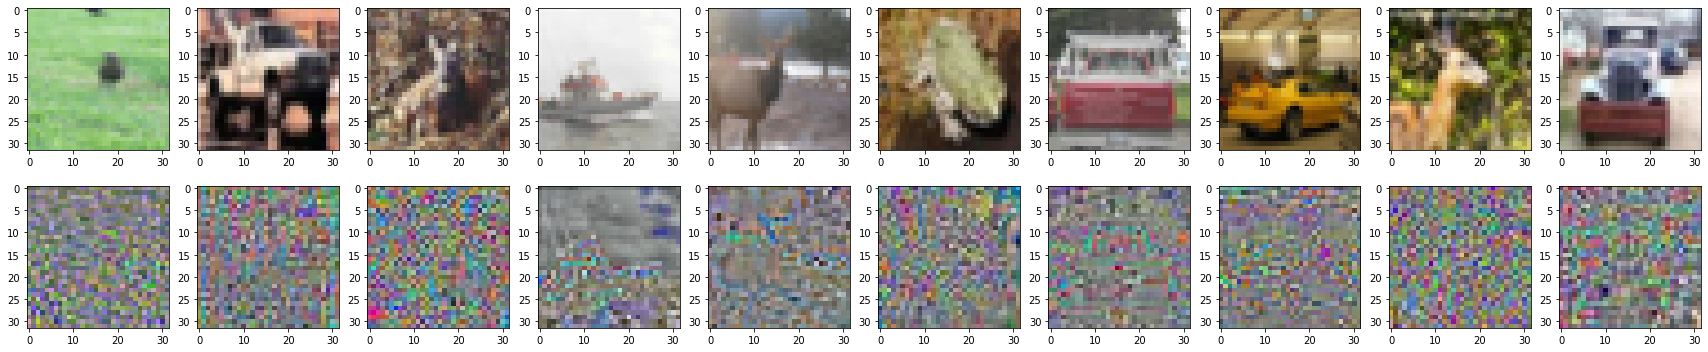

-------- Sigma: 0.167 -------
L2 Norm: 86.795
Cosine Similarity with Image: -0.059


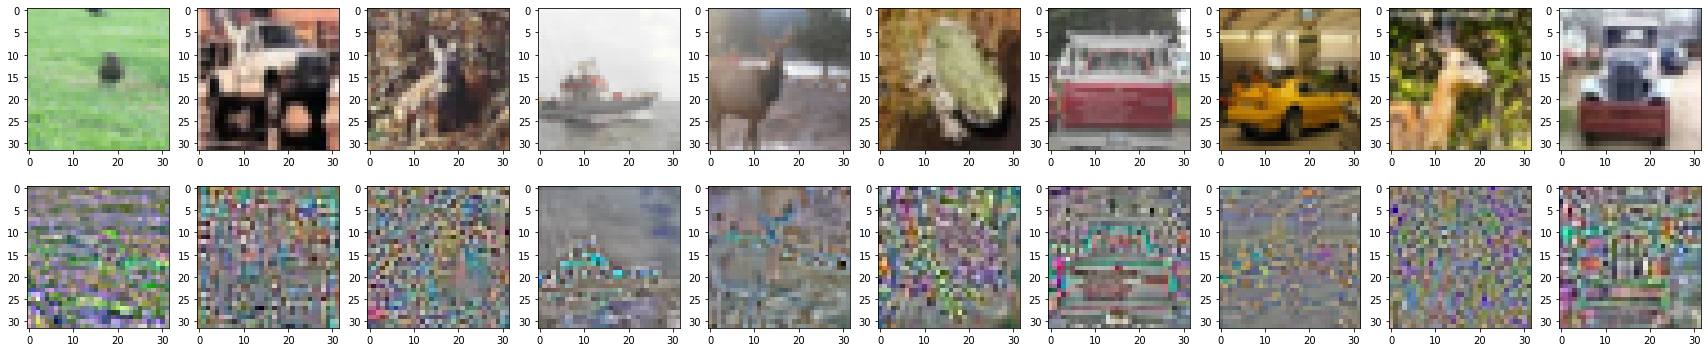

-------- Sigma: 0.464 -------
L2 Norm: 25.487
Cosine Similarity with Image: 0.037


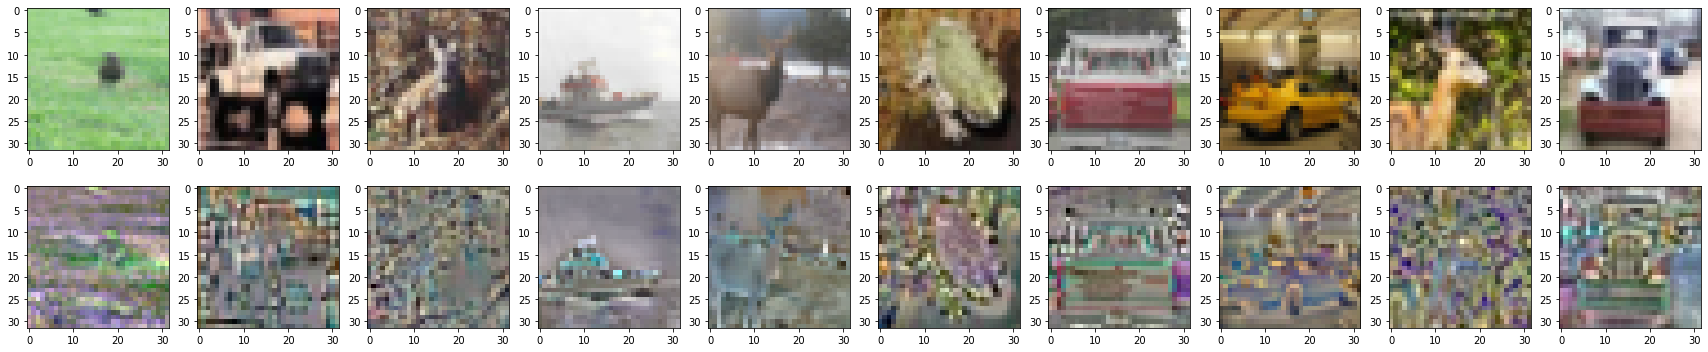

-------- Sigma: 1.292 -------
L2 Norm: 6.256
Cosine Similarity with Image: -0.347


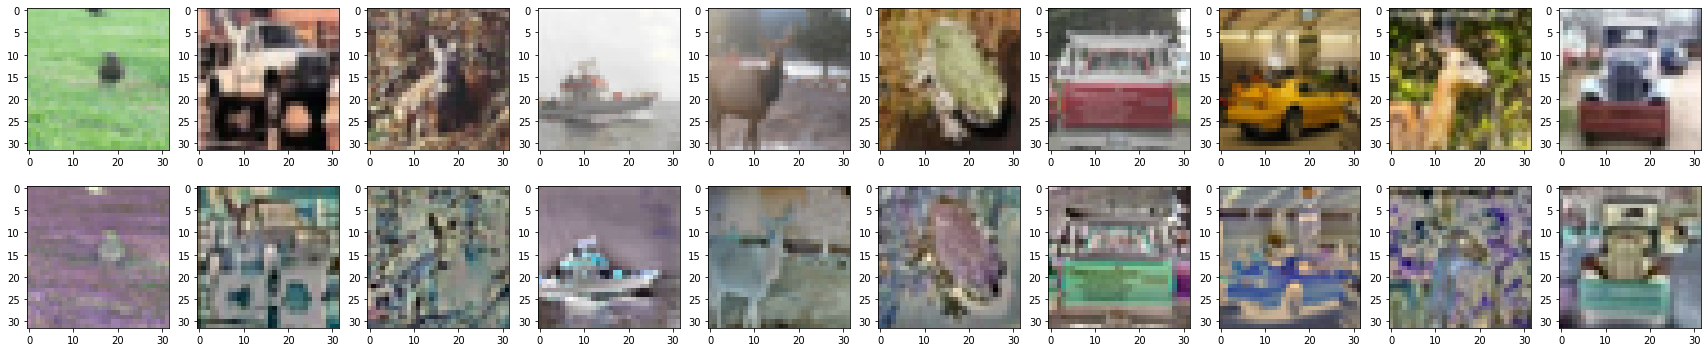

-------- Sigma: 3.594 -------
L2 Norm: 1.355
Cosine Similarity with Image: -0.895


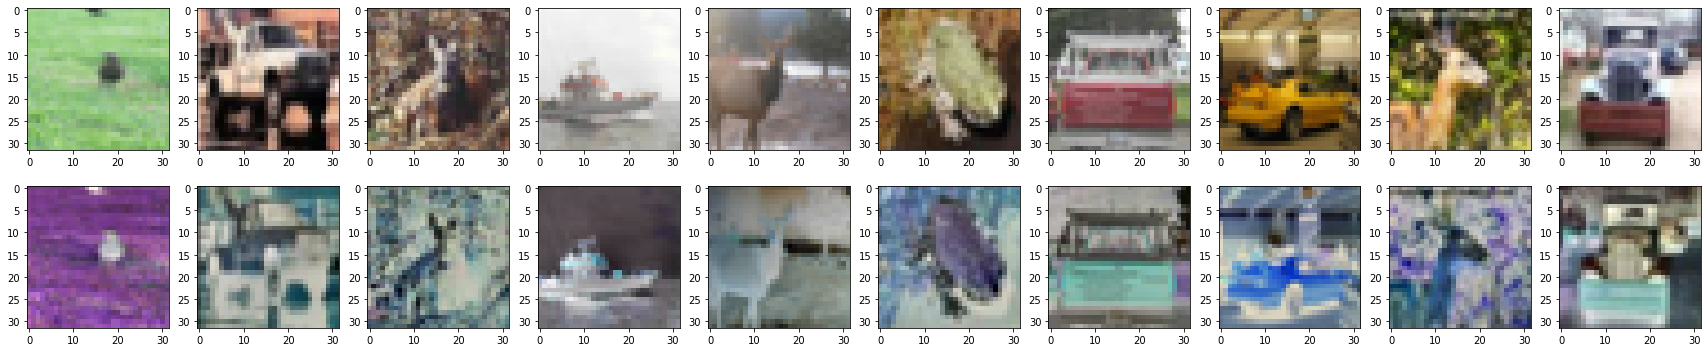

-------- Sigma: 10.000 -------
L2 Norm: 0.242
Cosine Similarity with Image: -0.991


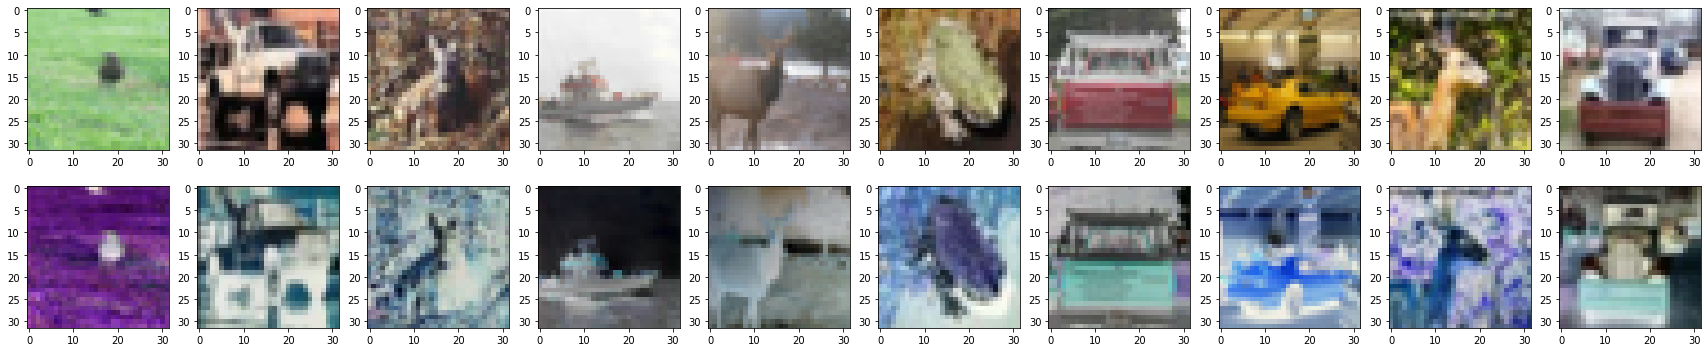

In [37]:
noise_level = np.logspace(-3, 1, num=10)
for sigma in noise_level:
    sigma = net.round_sigma(torch.Tensor([sigma]).to(device))
    #noisy_images = images + sigma * torch.randn([64, net.img_channels, net.img_resolution, net.img_resolution], device=device)
    D = net(images, sigma).to(torch.float32) # , class_labels
    score = (D - images) / sigma.item() ** 2

    print(f'-------- Sigma: {sigma.item():0.3f} -------')
    mean_length = torch.linalg.vector_norm(score, dim=(1,2,3)).mean()
    print(f'L2 Norm: {mean_length:.3f}')
    print(f'Cosine Similarity with Image: {np.mean( [torch.inner(images[idx].flatten(), score[idx].flatten()).item() / torch.linalg.vector_norm(images[idx].flatten()).item() / torch.linalg.vector_norm(score[idx].flatten()).item() for idx in range(batch_size)]):.3f}')

    #plt.hist(((score / score.abs().max()) * 127.5 + 128).detach().cpu().numpy().flatten())
    #plt.show()

    for idx in range(score.shape[0]):
        score[idx, :, :, :] = score[idx, :, :, :] / score[idx, :, :, :].abs().max() 
    _, axs = plt.subplots(nrows=2, ncols=10, figsize=(30, 6))
    for icol in range(10):

        img = (images[icol, :, :, :] * 127.5 + 128).clip(0, 255).to(torch.uint8)
        axs[0, icol].imshow(img.cpu().numpy().squeeze().transpose((1,2,0)))

        score_img = (score[icol, :, :, :]* 127.5 + 128).clip(0, 255).to(torch.uint8)
        axs[1, icol].imshow(score_img.cpu().numpy().squeeze().transpose((1,2,0)))
    plt.show()

    #save_image_grid(f'figures/scores/score_{sigma.item():0.3f}_rescalecd.png', score / score.abs().max())

Saving image grid to "figures/image_batch.png"...


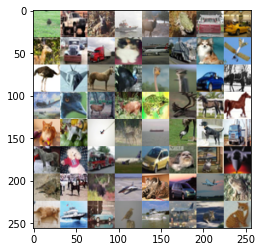

Done.


In [34]:
# for comparison, the original images
save_image_grid(f'figures/image_batch.png', images)

### for the noise level sigma=1, go over the test set and compute the score for all images

In [52]:
for idx, images in tqdm.tqdm(enumerate(iter(testloader))):
    images = images[0].to(device).to(torch.float32) * 2 -1
    sigma = net.round_sigma(torch.Tensor([1]).to(device))

    D = net(images, sigma).to(torch.float64) # , class_labels
    score = (D - images) / sigma.item() ** 2
    torch.save(score, f'data/cifar10-test-scores/score{idx}.pt')

10000it [03:09, 52.78it/s]
